In [1]:
#import
import h5py
import os
import numpy as np
from tifffile import imread, imsave, imwrite
from scipy.interpolate import interp1d
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from skimage import io
import random
from scipy.stats import ttest_ind as ttest
from scipy.interpolate import interp1d
import copy
import matplotlib.lines as mlines
import shutil
import scipy as sp
from tqdm import tqdm
import time
import scipy as sp
import h5py
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import errno
import os
import imageio
import os
#import cv2
import glob
import imageio
#import telegram
from tifffile import imread, imsave
import h5py
import matplotlib
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import tables


C:\Users\ag-bahl\AppData\Local\Temp\ipykernel_6352\2470098560.py:27: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


#### Set datetime (outdated but still implemented in some places)

In [2]:
datetime = "2022-04-12_11-23-06"

#### Read *.txt where target files are specified into list --> dt

In [3]:
with open(r'C:\Users\ag-bahl\Documents\functional_volume_characterization\raw\registered.txt') as f:
    dt = f.readlines()
    dt = [x[0:-1] if x[-1:] == '\n' else x for x in dt]

### Big class which imports files and makes data available in --> exp_list

##### Organization of exp_list

- **exp_list accessible with [i]**
    - *.hdf5_preprocessed   --> yields filename of selected dataset
    - *.datetime            --> yields datetime of selected dataset
    - *.dir_data            --> yields directory where selected dataset hdf5 is stored
    - *.name_of_planes      --> yields list of names of all planes in selected dataset
    - *.planes              --> **subobject for each plane within selected experiment; accessible with [i]**
        - *.z_name            --> yields name of selected plane
        - *.z                 --> yields name of selected plane as *int*
        - *.experiment_parent --> points to object of experiment, selected plane is part of
        - *.no_cells_in_plane --> yields number of cells in selected plane as *int*
        - *.avg_image         --> yields average image of selected plane as a numpy.ndarray; displayable with plt.imshow()
        - *.cells             --> **subobject for each cell within selected plane; accessible with [i]**
            - *.plane_parent --> points to object of plane, selected cell is part of
            - *.cell_no_10000 --> yields cell number with 10.000 to avoid 0 index problems as *int*
            - *.cell_no --> yields cell number as *int*
            - *.z --> yields name of plane the selected cell is part of as *int*
            - *.contour --> yields contour of selected cell as numpy.ndarray
            - *.mask --> yields mask of selected cell as numpy.ndarray
            - *.contour_mask --> yields contour_mask of selected cell as numpy.ndarray
            - *.centroid --> yields centroid of selected cell as a tuple
            - *.brs --> yields list of brainregions selected cell is located within
            - *.contour_reg --> yields registered contour of selected cell as numpy.ndarray
            - *.mask_reg --> yields registered mask of selected cell as numpy.ndarray
            - *.contour_mask_reg --> yields registered contour_mask of selected cell as numpy.ndarray
            - *.centroid_reg --> yields registered centroid of selected cell as a tuple

            - **TRACES OF LENGTH 160 CONTAIN NEUTRAL STIMULUS FROM PREVIOUS TRIAL; ONE TRIAL = TRACE[20:140]**

            - *.traces_stim0 --> unedited mean of stimulus 0 aligned traces of selected cell
            - *.traces_stim1 --> unedited mean of stimulus 1 aligned traces of selected cell
            - *.df_d0_stim0 --> df/d0 for mean of stimulus 0 aligned traces of selected cell
            - *.df_d0_stim1 --> df/d0 for mean of stimulus 1 aligned traces of selected cell
            - *.traces_normalized_stim0 --> df/d0 for mean of stimulus 0 aligned traces of selected cell standardized by standard deviation
            - *.traces_normalized_stim1 --> df/d0 for mean of stimulus 1 aligned traces of selected cell standardized by standard deviation
            - *.traces_stim0 --> df/d0 for mean of stimulus 0 aligned traces of selected cell standardized by standard deviation and pruned to only contain one trial
            - *.traces_stim1 --> df/d0 for mean of stimulus 1 aligned traces of selected cell standardized by standard deviation and pruned to only contain one trial
            - *.traces_std_intra_stim0 --> standard deviation within mean of unedited trace in reaction to stim 0 of selected cell
            - *.traces_std_intra_stim1 --> standard deviation within mean of unedited trace in reaction to stim 1 of selected cell
            - *.traces_std_extra_stim0 --> standard deviation between all of unedited reactions to stim 0 of selected cell
            - *.traces_std_extra_stim1 --> standard deviation between all of unedited reactions to stim 1 of selected cell
            - *.show() --> shows location of selected cell in plane
                - create_new [bool:default=True] = Determines if plane is drawn again (for drawing multiple target cells)
                - size [tuple:default=(10,10)] = Determines size of displayed image
                - mode [str:default=("c")] = Determines display mode (c=contour, m=mask, cm=contour mask)
                - alpha [int:default=1] = Determines opacity of cell marker
                - color [str:default="red"] = Determines color of cell marker
                - colormap [str:default="gray"] = Determines color scheme of plane
            - *.show_trace() --> shows unedited mean of reaction of selected cell to stim 0 and stim 1 and shows normalized df/d0 of selected cell to stim 0 and stim 1
                - location [bool:default=False] = Determines if location of cell in plane is shown

In [4]:
%%time
class experiment:

    def __init__(self,datetime=datetime):
        self.datetime = datetime
        self.dir_data = "C:/Users/ag-bahl/Documents/functional_volume_characterization/raw/" + self.datetime + "/"


    def load_data(self, which_planes = True):
        class cell:
            def __init__(self, cell_no, plane_parent):
                self.plane_parent = plane_parent
                self.dir_data = self.plane_parent.experiment_parent.dir_data
                self.cell_no_10000 = cell_no
                self.cell_no = cell_no - 10000
                self.z = plane_parent.z

                self.contour = np.array(plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation']['unit_contours'][str(self.cell_no_10000)])
                self.mask = np.array(plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation']['unit_masks'][str(self.cell_no_10000)]).transpose()
                self.mask[:,[0, 1]] = self.mask[:,[1, 0]]
                self.contour_mask = np.array(plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation']['unit_contour_masks'][str(self.cell_no_10000)]).transpose()
                self.contour_mask[:,[0, 1]] = self.contour_mask[:,[1, 0]]
                self.centroid = tuple(plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation']['unit_centroids'][self.cell_no])

                self.brs = []
                try:
                    for indi in np.where(np.array(plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation']['region_mask_units_matrix_ants_registered'])[:,self.cell_no])[0]:
                        self.brs.append(plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation']['region_mask_units_matrix_ants_registered'].attrs[str(indi)])


                    if 'unit_contours_ants_registered' in plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation'].keys():
                        self.contour_reg = np.array(plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation']['unit_contours_ants_registered'][str(self.cell_no_10000)])
                    if 'unit_masks_ants_registered' in plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation'].keys():
                        self.mask_reg = np.array(plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation']['unit_masks_ants_registered'][str(self.cell_no_10000)]).transpose()
                    if 'unit_contour_masks_ants_registered' in plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation'].keys():
                        self.contour_mask_reg = np.array(plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation']['unit_contour_masks_ants_registered'][str(self.cell_no_10000)]).transpose()
                    if 'unit_centroids_ants_registered' in plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation'].keys():
                        self.centroid_reg = tuple(plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation']['unit_centroids_ants_registered'][self.cell_no])
                except:
                    pass


                #mean of unedited trials
                self.traces_stim0 = np.nanmean(np.array(plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation']['stimulus_aligned_dynamics']['stimulus0000']['F'])[:,self.cell_no,:],axis=0)
                self.traces_stim1 = np.nanmean(np.array(plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation']['stimulus_aligned_dynamics']['stimulus0001']['F'])[:,self.cell_no,:],axis=0)

                #calculation  of df/d0
                temp0 = [(trial - np.nanmean(trial[20:30])) / np.nanmean(trial[20:30]) for trial in np.array(plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation']['stimulus_aligned_dynamics']['stimulus0000']['F'])[:,self.cell_no,:]]

                temp1 = [(trial - np.nanmean(trial[20:30])) / np.nanmean(trial[20:30]) for trial in np.array(plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation']['stimulus_aligned_dynamics']['stimulus0001']['F'])[:,self.cell_no,:]]

                #mean df/d0
                temp0 = np.nanmean(temp0,axis=0)
                temp1 = np.nanmean(temp1,axis=0)

                self.df_d0_stim0 = temp0
                self.df_d0_stim1 = temp1

                #normalizing df/d0
                self.traces_normalized_stim0 = (temp0 - np.nanmean(temp0))/np.nanstd(temp0)
                self.traces_normalized_stim1 = (temp1 - np.nanmean(temp1))/np.nanstd(temp1)

                self.stim0_120 = self.traces_normalized_stim0[20:140]
                self.stim1_120 = self.traces_normalized_stim1[20:140]

                #calculation of std in average trial
                self.traces_std_intra_stim0 = np.nanstd(self.traces_stim0)
                self.traces_std_intra_stim1 = np.nanstd(self.traces_stim1)

                #calculation of std between different trials
                self.traces_std_extra_stim0 = np.nanmean(np.nanstd(np.array(plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation']['stimulus_aligned_dynamics']['stimulus0000']['F'])[:,self.cell_no,:],axis=0))
                self.traces_std_extra_stim1 = np.nanmean(np.nanstd(np.array(plane_parent.experiment_parent.hdf5_preprocessed[plane_parent.z_name]['cellpose_segmentation']['stimulus_aligned_dynamics']['stimulus0001']['F'])[:,self.cell_no,:],axis=0))

            def show_trace(self,location=False):
                """
                Displays trace of cell

                location [bool:default=False] = Determines if location of cell in plane is shown
                """
                if location:
                    self.show()
                f,axs = plt.subplots(2,2,figsize=(15,10))
                axs[0][0].set_title('unedited mean of stim0 reaction')
                axs[0][0].plot(self.traces_stim0[20:140])
                axs[0][1].set_title('unedited mean of stim1 reaction')
                axs[0][1].plot(self.traces_stim1[20:140])



                axs[1][0].set_title('normalized df/d0 mean stim0 reaction')
                axs[1][0].plot(self.traces_normalized_stim0[20:140])
                axs[1][1].set_title('normalized df/d0 mean stim1 reaction')
                axs[1][1].plot(self.traces_normalized_stim1[20:140])


            def show(self,create_new=True, size=(10,10),mode="c",alpha=1,color='red',colormap='gray'):
                """
                Displays location of cell in plane

                create_new [bool:default=True] = Determines if plane is drawn again (for drawing multiple target cells)
                size [tuple:default=(10,10)] = Determines size of displayed image
                mode [str:default=("c")] = Determines display mode (c=contour, m=mask, cm=contour mask)
                alpha [int:default=1] = Determines opacity of cell marker
                color [str:default="red"] = Determines color of cell marker
                colormap [str:default="gray"] = Determines colr scheme of plane
                """
                if create_new:
                    self.plane_parent.show(size=size,colormap=colormap)

                if mode == 'c':
                    plt.plot(self.contour[:,0],self.contour[:,1],alpha=alpha,c=color)
                elif mode == 'm':
                    plt.plot(self.mask[:,0],self.mask[:,1],alpha=alpha,c=color)
                elif mode == 'cm':
                    plt.plot(self.contour_mask[:,0],self.contour_mask[:,1],alpha=alpha,c=color)
        class plane:
            def __init__(self, z, experiment_parent):
                self.z_name = z
                self.z = int(z[-4:])
                self.experiment_parent = experiment_parent
                self.no_cells_in_plane = len(experiment_parent.hdf5_preprocessed[self.z_name]['cellpose_segmentation']['unit_names'])

                temp = np.array(experiment_parent.hdf5_preprocessed[z]["imaging_green_channel_time_averaged"])
                self.avg_image = np.clip(temp,np.percentile(temp,2), np.percentile(temp, 98))-10000 #remove 10000 if not using cellpose

                self.cells = dict()                                                #important. Implemented as a dictionary with integer as the cells

                for cell_no in experiment_parent.hdf5_preprocessed[self.z_name]['cellpose_segmentation']['unit_names']:

                    self.cells[cell_no- 10000] =  cell(cell_no, self)

            def show(self,size=(10,10),colormap='gray'):
                plt.figure(figsize=size)
                plt.axis("off")
                plt.imshow(self.avg_image,cmap=colormap)

        if os.path.isfile(self.dir_data + self.datetime + '_preprocessed_data.h5'):
            self.hdf5_preprocessed = h5py.File(self.dir_data + self.datetime + '_preprocessed_data.h5', 'r')
            print(f'{self.datetime}_preprocessed_data.h5 was loaded successfully.')

        if not os.path.isfile(self.dir_data + self.datetime + '_preprocessed_data.h5'):
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), self.dir_data + self.datetime + '_preprocessed_data.h5')

        if which_planes and type(which_planes) == bool:

            self.name_of_planes = [x for x in list(self.hdf5_preprocessed.keys()) if 'z_plane' in x]

        elif type(which_planes) != bool and type(which_planes) == int:
            self.name_of_planes = ['z_plane' + str(which_planes).zfill(4)]

        elif type(which_planes) != bool and type(which_planes) != int:
            raise ValueError(f'Please input plane as an integer. "{which_planes}" is not an integer.')

        self.planes = dict()                                                #important. Implemented as a dictionary with integer as the planes

        for z in self.name_of_planes:
            self.planes[int(z[-4:])] = plane(z, self)
            print(f'Finished plane {int(z[-4:])}')

        self.all_cells = pd.DataFrame()

        for p in self.planes.values():

            for c in p.cells.values():
                temp_dict = dict()
                temp_dict['cell_no'] = c.cell_no
                temp_dict['z'] = p.z
                temp_dict['std_intra/std_extra_stim0'] = c.traces_std_intra_stim0/c.traces_std_extra_stim0
                temp_dict['std_intra/std_extra_stim1'] = c.traces_std_intra_stim1/c.traces_std_extra_stim1
                temp_dict['normalized_stim0'] = c.traces_normalized_stim0[20:140]
                temp_dict['normalized_stim1'] = c.traces_normalized_stim1[20:140]




                if c.centroid[0] < 400:
                    temp_dict['centroid_pos'] = 0
                elif c.centroid[0] >= 400:
                    temp_dict['centroid_pos'] = 1

                temp_dict['centroid_x'] = c.centroid[0]
                temp_dict['centroid_y'] = c.centroid[1]

                self.all_cells = self.all_cells.append(temp_dict,ignore_index=True)





        #self.hdf5_preprocessed.close()



exp_list = []
for i,date in enumerate(dt):
    exp_list.append(experiment(date))
    exp_list[-1].load_data(5)

2021-12-13_11-30-23_preprocessed_data.h5 was loaded successfully.
Finished plane 5


<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed fro

2021-11-30_08-29-39_preprocessed_data.h5 was loaded successfully.
Finished plane 5


<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed fro

2022-01-17_18-42-05_preprocessed_data.h5 was loaded successfully.
Finished plane 5


<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed fro

2021-12-14_09-26-15_preprocessed_data.h5 was loaded successfully.
Finished plane 5


<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed fro

2021-11-29_18-40-49_preprocessed_data.h5 was loaded successfully.
Finished plane 5


<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed fro

CPU times: total: 7min 12s
Wall time: 7min 16s


<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:183: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


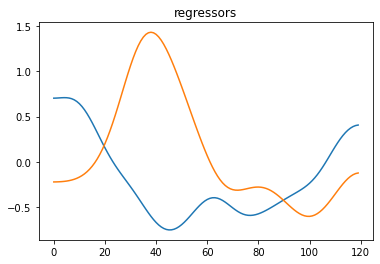

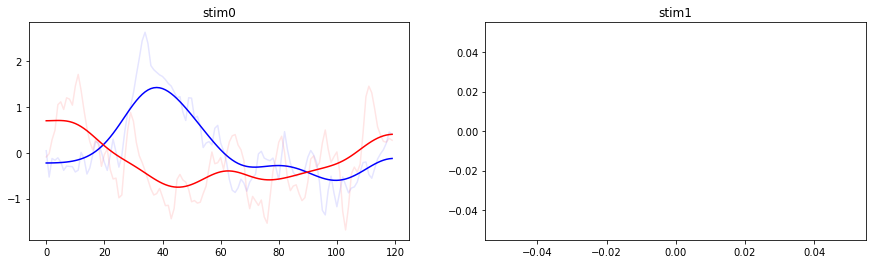

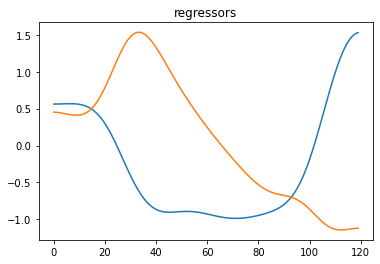

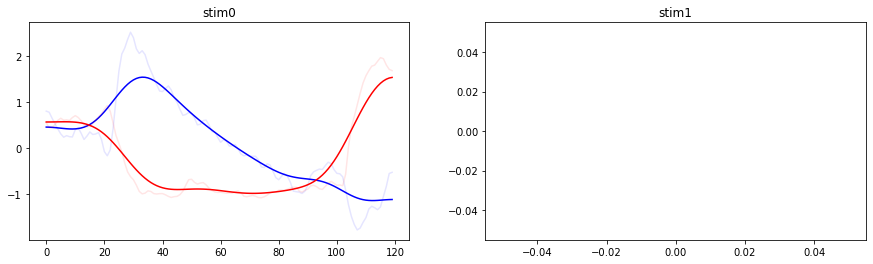

<timed exec>:182: RuntimeWarning: Mean of empty slice
<timed exec>:183: RuntimeWarning: Mean of empty slice


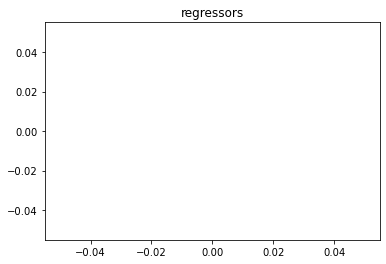

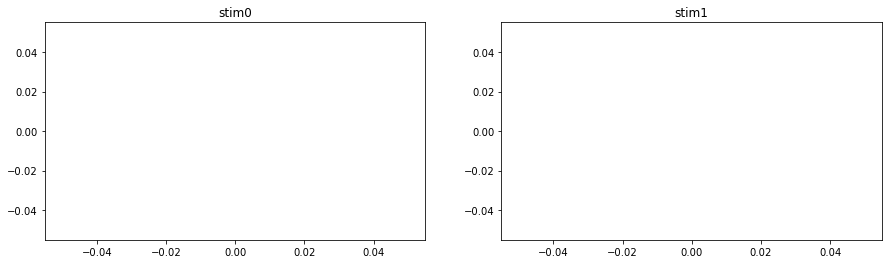

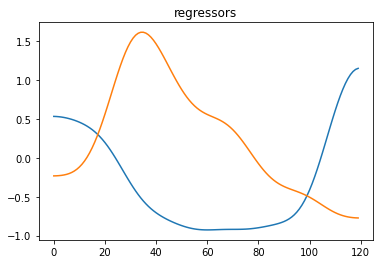

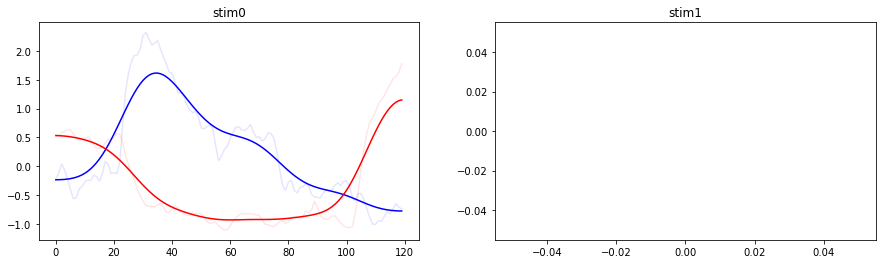

<timed exec>:182: RuntimeWarning: Mean of empty slice
<timed exec>:183: RuntimeWarning: Mean of empty slice


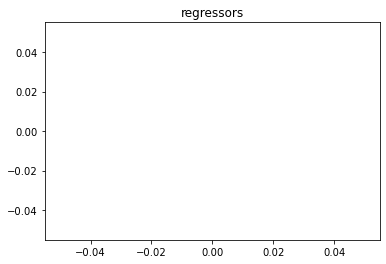

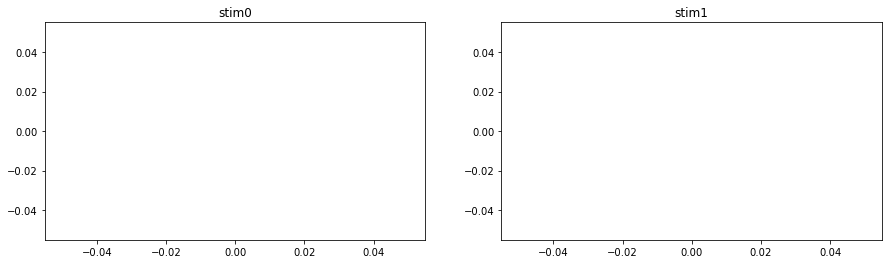

CPU times: total: 4.08 s
Wall time: 4.08 s


In [5]:
%%time
class analyzer:
    def __init__(self,experiment):
        self.ex = experiment
        self.all_cells = self.ex.all_cells



    def point_and_mean_rule(self,start=0,middle=40,end=80,ks=2.5,ke=2.3,krs=1.1,kre=1.4):
        self.all_cells_corrected = self.all_cells.copy(deep=True)
        self.all_cells_corrected = self.all_cells_corrected.reset_index(drop=True)
        temp0 = []
        temp1 = []
        for i, item in self.all_cells_corrected.iterrows():
            self.all_cells_corrected.at[i,'normalized_stim0'] = item['normalized_stim0'] - np.nanmin(item['normalized_stim0'])
            self.all_cells_corrected.at[i,'normalized_stim1'] = item['normalized_stim1'] - np.nanmin(item['normalized_stim1'])

            temp0.append(self.all_cells_corrected.at[i,'normalized_stim0'])
            temp1.append(self.all_cells_corrected.at[i,'normalized_stim1'])
        self.corrected_traces0 = np.array(temp0)
        self.corrected_traces1 = np.array(temp1)
        for i, item in self.all_cells_corrected.iterrows():

            smooth0 = sp.ndimage.gaussian_filter(item['normalized_stim0'],7)
            smooth1 = sp.ndimage.gaussian_filter(item['normalized_stim1'],7)

            if smooth0[middle] > smooth0[start] * ks and  smooth0[middle] > smooth0[end] * ke and smooth0[end] > smooth0[end+20]:
                self.all_cells_corrected.at[i,'rebound_ipsi_response0'] = True
            else:
                self.all_cells_corrected.at[i,'rebound_ipsi_response0'] = False

            if smooth1[middle] > smooth1[start] * ks and  smooth1[middle] > smooth1[end] * ke and smooth1[end] > smooth1[end+20] * ke:
                self.all_cells_corrected.at[i,'rebound_ipsi_response1'] = True
            else:
                self.all_cells_corrected.at[i,'rebound_ipsi_response1'] = False


            if np.mean(smooth0[40:80]) < np.mean(smooth0[0:20]) * krs and  np.mean(smooth0[30:80]) < np.mean(smooth0[100:120]) * kre: #and smooth0[end] > smooth0[end+20]:
                self.all_cells_corrected.at[i,'rebound_contra_response0'] = True
            else:
                self.all_cells_corrected.at[i,'rebound_contra_response0'] = False

            if np.mean(smooth1[40:80]) < np.mean(smooth1[0:20]) * krs and  np.mean(smooth1[30:80]) < np.mean(smooth1[100:120]) * kre: #and smooth1[end] > smooth1[end+20] * ke:
                self.all_cells_corrected.at[i,'rebound_contra_response1'] = True
            else:
                self.all_cells_corrected.at[i,'rebound_contra_response1'] = False

            if np.mean(smooth0[0:20])* 1.1 < np.mean(smooth0[100:120]) :
                self.all_cells_corrected.at[i,'higher_end0'] = True
            else:
                self.all_cells_corrected.at[i,'higher_end0'] = False


            if np.mean(smooth1[0:20])* 1.1 < np.mean(smooth1[100:120]) :
                self.all_cells_corrected.at[i,'higher_end1'] = True
            else:
                self.all_cells_corrected.at[i,'higher_end1'] = False

            self.all_cells_corrected.at[i,'corr_coeff'] = np.corrcoef(smooth0,smooth1)[0][1]


            if np.std(smooth0[0:30]) > np.std(smooth0[40:100]):
                self.all_cells_corrected.at[i,'std0'] = True
            else:
                self.all_cells_corrected.at[i,'std0'] = False

            if np.std(smooth1[0:30]) > np.std(smooth1[40:100]):
                self.all_cells_corrected.at[i,'std1'] = True
            else:
                self.all_cells_corrected.at[i,'std1'] = False





    def show_trace(self,cell=0,z=0,smooth=True,alph=0.2):
        f,axs = plt.subplots(1,2,figsize=(15,4),sharey=True,)

        temp0 = self.all_cells[(self.all_cells['z']==z)&(self.all_cells['cell_no']==cell)]['normalized_stim0'].to_list()[0]
        temp1 = self.all_cells[(self.all_cells['z']==z)&(self.all_cells['cell_no']==cell)]['normalized_stim1'].to_list()[0]

        axs[0].plot(temp0,alpha=alph,c='red')
        axs[1].plot(temp1,alpha=alph,c='red')

        axs[0].plot(sp.ndimage.gaussian_filter(temp0,10))
        axs[1].plot(sp.ndimage.gaussian_filter(temp1,10))

        axs[0].set_title('stim0')
        axs[1].set_title('stim1')

test = analyzer(analyzer(exp_list[0]))
test.point_and_mean_rule(start=0,middle=40,end=80,ks=1,ke=2,krs=1.1,kre=1.2)

ana_list = []
subset0_list = []
for i,exp in enumerate(exp_list):
    ana_list.append(analyzer(exp))
    ana_list[-1].point_and_mean_rule(start=0,middle=40,end=80,ks=1,ke=2,krs=1.2,kre=1.2)



    subset0_list.append(ana_list[-1].all_cells_corrected)



    subset0_list[-1] = subset0_list[-1][(((subset0_list[-1]['rebound_contra_response0']==True)
                                          &(subset0_list[-1]['rebound_ipsi_response1']==True)
                                          &(subset0_list[-1]['std0']))
                                         |((subset0_list[-1]['rebound_contra_response1']==True)
                                           &(subset0_list[-1]['rebound_ipsi_response0']==True)
                                           &(subset0_list[-1]['std1'])))
                                        &(subset0_list[-1]['corr_coeff']<=0)].sort_values('corr_coeff',ascending=True)


    subset0_list[-1] = subset0_list[-1][(subset0_list[-1]["higher_end0"])|subset0_list[-1]["higher_end1"]].sort_values("cell_no")



def create_trace_array(df,experiment,determinator):
    ipsi0 = []
    ipsi1 = []
    contra0 = []
    contra1 =[]

    array_list = [ipsi0,ipsi1,contra0,contra1]


    filler_array = np.empty((120,1))
    filler_array[:] = np.nan


    for i,item in df.iterrows():
        if item[determinator + '0'] == True:
            ipsi0.append(experiment.planes[item['z']].cells[item['cell_no']].stim0_120)
            contra0.append(experiment.planes[item['z']].cells[item['cell_no']].stim1_120)
        if item[determinator + '0'] == False:
            ipsi1.append(experiment.planes[item['z']].cells[item['cell_no']].stim1_120)

            contra1.append(experiment.planes[item['z']].cells[item['cell_no']].stim0_120)


    ipsi0_smooth = sp.ndimage.gaussian_filter(ipsi0,8)
    ipsi1_smooth = sp.ndimage.gaussian_filter(ipsi1,8)


    if len(contra0) == 0:
        contra0 = np.empty((120,1))
        contra0[:] = np.nan
    else:
        contra0 = np.nanmean(np.array(contra0),axis=0)
        contra0 = np.reshape(contra0,(120,1))

    if len(contra1) == 0:
        contra1 = np.empty((120,1))
        contra1[:] = np.nan
    else:
        contra1 = np.nanmean(np.array(contra1),axis=0)
        contra1 = np.reshape(contra1,(120,1))

    if len(ipsi0) == 0:
        ipsi0 = np.empty((120,1))
        ipsi0[:] = np.nan
    else:
        ipsi0 = np.nanmean(np.array(ipsi0),axis=0)
        ipsi0 = np.reshape(ipsi0,(120,1))

    if len(ipsi1) == 0:
        ipsi1 = np.empty((120,1))
        ipsi1[:] = np.nan
    else:
        ipsi1 = np.nanmean(np.array(ipsi1),axis=0)
        ipsi1 = np.reshape(ipsi1,(120,1))



    contra0_smooth = sp.ndimage.gaussian_filter(contra0,8)
    contra1_smooth = sp.ndimage.gaussian_filter(contra1,8)

    ipsi0_smooth = sp.ndimage.gaussian_filter(ipsi0,8)
    ipsi1_smooth = sp.ndimage.gaussian_filter(ipsi1,8)


    contra_regressor = np.nanmean(np.hstack((contra0_smooth,contra1_smooth)),axis=1)
    ipsi_regressor = np.nanmean(np.hstack((ipsi0_smooth,ipsi1_smooth)),axis=1)

    plt.plot(contra_regressor)
    plt.plot(ipsi_regressor)
    plt.title('regressors')
    plt.show()

    f,axs = plt.subplots(1,2,figsize=(15,4))
    axs[0].plot(ipsi0,alpha=0.1,c='blue')
    axs[0].plot(ipsi0_smooth,c='blue')
    axs[0].plot(contra0,c='red',alpha=0.1)
    axs[0].plot(contra0_smooth,c='red')
    axs[0].set_title('stim0')

    axs[1].plot(ipsi1_smooth,c='blue')
    axs[1].plot(ipsi1,alpha=0.1,c='blue')
    axs[1].plot(contra1,c='red',alpha=0.1)
    axs[1].plot(contra1_smooth,c='red')
    axs[1].set_title('stim1')
    plt.show()

    return contra_regressor,ipsi_regressor


contra_regressor_list = []
ipsi_regressor_list = []


for i,subset in enumerate(subset0_list):
    temp_c_reg, temp_i_reg = create_trace_array(subset,exp_list[i],'rebound_ipsi_response')

    contra_regressor_list.append(temp_c_reg)
    ipsi_regressor_list.append(temp_i_reg)


# contra_regressor,ipsi_regressor = create_trace_array(subset0,lol,'rebound_ipsi_response')

In [6]:
xmax = 0
ymax = 0

xmin = 10000
ymin = 10000

for exp in exp_list:
    for plane in exp.planes:
        for cell in exp.planes[plane].cells:

            if np.max(exp.planes[plane].cells[cell].mask_reg[:,1]) >= xmax:
                xmax = np.max(exp.planes[plane].cells[cell].mask_reg[:,1])

            if np.max(exp.planes[plane].cells[cell].mask_reg[:,2]) >= ymax:
                ymax = np.max(exp.planes[plane].cells[cell].mask_reg[:,2])

            if np.min(exp.planes[plane].cells[cell].mask_reg[:,1]) <= xmin:
                xmin = np.min(exp.planes[plane].cells[cell].mask_reg[:,1])

            if np.min(exp.planes[plane].cells[cell].mask_reg[:,2]) <= ymin:
                ymin = np.min(exp.planes[plane].cells[cell].mask_reg[:,2])

In [7]:
def array_writer(array,mask,value,x_off,y_off):
    if value >= 0:
        for y in np.unique(mask[:,2]):

            xmin = np.min(mask[mask[:,2]==y][:,1])
            xmax = np.max(mask[mask[:,2]==y][:,1])
            array[xmin-x_off:xmax-x_off,y-y_off] = array[xmin-x_off:xmax-x_off,y-y_off] + value


    return array

In [8]:
for i0,ana in enumerate(ana_list):
    for i,item in ana.all_cells_corrected.iterrows():

        smooth0 = sp.ndimage.gaussian_filter(item['normalized_stim0'],7)
        smooth1 = sp.ndimage.gaussian_filter(item['normalized_stim1'],7)

        ana_list[i0].all_cells_corrected.at[i,'corr_contra_regressor0'] = np.corrcoef(contra_regressor_list[i0],smooth0)[0][1]
        ana_list[i0].all_cells_corrected.at[i,'corr_contra_regressor1'] = np.corrcoef(contra_regressor_list[i0],smooth1)[0][1]

        ana_list[i0].all_cells_corrected.at[i,'corr_ipsi_regressor0'] = np.corrcoef(ipsi_regressor_list[i0],smooth0)[0][1]
        ana_list[i0].all_cells_corrected.at[i,'corr_ipsi_regressor1'] = np.corrcoef(ipsi_regressor_list[i0],smooth1)[0][1]

cells = pd.DataFrame(columns = ana_list[i0].all_cells_corrected.columns)



cells["x_contour_reg"] = 0
cells["y_contour_reg"] = 0
cells["z_contour_reg"] = 0
cells["x_contour_reg"] = cells["x_contour_reg"].astype("object")
cells["y_contour_reg"] = cells["y_contour_reg"].astype("object")
cells["z_contour_reg"] = cells["z_contour_reg"].astype("object")

cells["x_contour"] = 0
cells["y_contour"] = 0
cells["x_contour"] = cells["x_contour"].astype("object")
cells["y_contour"] = cells["y_contour"].astype("object")





for i0,ana in enumerate(ana_list):
    ana.all_cells_corrected.loc[:,"internal_exp_no"] = int(i0)

    print(ana)
    cells = pd.concat([cells,ana.all_cells_corrected])
cells = cells.reset_index(drop=True)
cells["internal_exp_no"] = cells["internal_exp_no"].astype(int)
for i,item in cells.iterrows():
    cells.loc[i,"unique_cell_no"] = i

    cells.loc[i,"mask_max_x"] = np.max(exp_list[item["internal_exp_no"]].planes[item["z"]].cells[item["cell_no"]].mask_reg[:,1])
    cells.loc[i,"mask_max_y"] = np.max(exp_list[item["internal_exp_no"]].planes[item["z"]].cells[item["cell_no"]].mask_reg[:,2])
    cells.loc[i,"mask_min_x"] = np.min(exp_list[item["internal_exp_no"]].planes[item["z"]].cells[item["cell_no"]].mask_reg[:,1])
    cells.loc[i,"mask_min_y"] = np.min(exp_list[item["internal_exp_no"]].planes[item["z"]].cells[item["cell_no"]].mask_reg[:,2])
    cells.loc[i,"z_reg"] = np.nanmean(exp_list[item["internal_exp_no"]].planes[item["z"]].cells[item["cell_no"]].mask_reg[:,0])
    cells.loc[i,"x_centroid_reg"] = np.nanmean(exp_list[item["internal_exp_no"]].planes[item["z"]].cells[item["cell_no"]].centroid_reg[1])
    cells.loc[i,"z_centroid_reg"] = np.nanmean(exp_list[item["internal_exp_no"]].planes[item["z"]].cells[item["cell_no"]].centroid_reg[2])
    cells.loc[i,"y_centroid_reg"] = np.nanmean(exp_list[item["internal_exp_no"]].planes[item["z"]].cells[item["cell_no"]].centroid_reg[0])
    cells.loc[i,"dir_data"] = exp_list[item["internal_exp_no"]].planes[item["z"]].cells[item["cell_no"]].dir_data
    try:
        cells.iat[i,-16] = exp_list[int(item["internal_exp_no"])].planes[int(item["z"])].cells[int(item["cell_no"])].contour_reg[:,0]
        cells.iat[i,-15] = exp_list[int(item["internal_exp_no"])].planes[int(item["z"])].cells[int(item["cell_no"])].contour_reg[:,1]
        cells.iat[i,-14] = exp_list[int(item["internal_exp_no"])].planes[int(item["z"])].cells[int(item["cell_no"])].contour_reg[:,2]
        cells.iat[i,-13] = exp_list[int(item["internal_exp_no"])].planes[int(item["z"])].cells[int(item["cell_no"])].contour[:,0]
        cells.iat[i,-12] = exp_list[int(item["internal_exp_no"])].planes[int(item["z"])].cells[int(item["cell_no"])].contour[:,1]
    except:
        cells.iat[i,-15] = exp_list[int(item["internal_exp_no"])].planes[int(item["z"])].cells[int(item["cell_no"])].contour_reg[:,0]
        cells.iat[i,-14] = exp_list[int(item["internal_exp_no"])].planes[int(item["z"])].cells[int(item["cell_no"])].contour_reg[:,1]
        cells.iat[i,-13] = exp_list[int(item["internal_exp_no"])].planes[int(item["z"])].cells[int(item["cell_no"])].contour_reg[:,2]
        cells.iat[i,-12] = exp_list[int(item["internal_exp_no"])].planes[int(item["z"])].cells[int(item["cell_no"])].contour[:,0]
        cells.iat[i,-11] = exp_list[int(item["internal_exp_no"])].planes[int(item["z"])].cells[int(item["cell_no"])].contour[:,1]




cells = cells.reset_index(drop=True)


In [9]:
#just treshold selection
treshold = 0.9
selected_cells = cells[((cells['corr_contra_regressor0']>=treshold)&(cells['corr_ipsi_regressor1']>=treshold)&(cells['centroid_pos']==1))|
                       ((cells['corr_contra_regressor1']>=treshold)&(cells['corr_ipsi_regressor0']>=treshold)&(cells['centroid_pos']==0))].sort_values('corr_contra_regressor0',ascending=False)

In [10]:
#look for treshold that gives at 20 cells per fish
selected_cells_per_iep = pd.DataFrame(columns = cells.columns)


for iep in cells.internal_exp_no.unique():

    for x in np.linspace(1,0,num=1000):
        treshold = x

        sc = cells[(((cells['corr_contra_regressor0']>=treshold)
                     &(cells['corr_ipsi_regressor1']>=treshold))|
                    ((cells['corr_contra_regressor1']>=treshold)
                     &(cells['corr_ipsi_regressor0']>=treshold)))
                   &(cells['centroid_y']>=100)
                   &(cells['internal_exp_no']==iep)].sort_values('corr_contra_regressor0',ascending=False)


        if len(sc)>=20:

            selected_cells_per_iep = pd.concat([selected_cells_per_iep,sc])
            selected_cells_per_iep.loc[selected_cells_per_iep["internal_exp_no"]==iep,"selection_treshold"] = x
            break

selected_cells_per_iep
selected_cells_per_iep.groupby("internal_exp_no").size()

internal_exp_no
0    20
1    20
3    20
dtype: int64

In [11]:
#look for treshold that gives 100 best cells
for x in np.linspace(1,0,num=1000):
    treshold = x
    subset1 = cells
    selected_cells_100 = cells[(((cells['corr_contra_regressor0']>=treshold)&(cells['corr_ipsi_regressor1']>=treshold))|
                                ((cells['corr_contra_regressor1']>=treshold)&(cells['corr_ipsi_regressor0']>=treshold)))&(cells['centroid_y']>=200)].sort_values('corr_contra_regressor0',ascending=False)

    if len(selected_cells_100)>=100:
        break
selected_cells_100.sort_values("centroid_y")
selected_cells_100.groupby("internal_exp_no").size()

internal_exp_no
0    31
1    52
3    17
dtype: int64

In [12]:
# enter prefered version of selection of cells df (selected_cells, selected_cells_per_iep, selected_cells_100)
selection = selected_cells

In [13]:
selected_cells_contra = []
selected_cells_ipsi = []
treshold = 0.8

for i,item in selection.iterrows():
    if item['corr_contra_regressor0'] >=treshold and item['rebound_contra_response0'] and item['corr_coeff']<= 0:
        selected_cells_contra.append(item['normalized_stim0'])
        selected_cells_ipsi.append(item['normalized_stim1'])
    elif item['corr_contra_regressor1'] >=treshold and item['rebound_contra_response1'] and item['corr_coeff']<= 0:
        selected_cells_contra.append(item['normalized_stim1'])
        selected_cells_ipsi.append(item['normalized_stim0'])

In [14]:
cells["response_stim0"]="a"
cells["response_stim1"]="a"
cells["response_stim0"] = cells["response_stim0"].astype("object")
cells["response_stim1"] = cells["response_stim1"].astype("object")

for i, item in cells.iterrows():
    cells.iat[i,-2] = exp_list[int(item["internal_exp_no"])].planes[int(item["z"])].cells[int(item["cell_no"])].df_d0_stim0
    cells.iat[i,-1] = exp_list[int(item["internal_exp_no"])].planes[int(item["z"])].cells[int(item["cell_no"])].df_d0_stim1

cells["selected_cell"]=False
for ien,z,cell_no in zip(selection['internal_exp_no'],selection['z'],selection['cell_no']):
    cells.loc[(cells["cell_no"]==cell_no)&(cells["z"]==z)&(cells["internal_exp_no"]==ien),"selected_cell"]=True

In [15]:
cells.to_hdf("cells.hdf5",'cells')

C:\Users\ag-bahl\AppData\Local\Temp\ipykernel_6352\2630174911.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->Index(['cell_no', 'z', 'std_intra/std_extra_stim0',
       'std_intra/std_extra_stim1', 'normalized_stim0', 'normalized_stim1',
       'centroid_pos', 'centroid_x', 'centroid_y', 'rebound_ipsi_response0',
       'rebound_ipsi_response1', 'rebound_contra_response0',
       'rebound_contra_response1', 'higher_end0', 'higher_end1', 'corr_coeff',
       'std0', 'std1', 'corr_contra_regressor0', 'corr_contra_regressor1',
       'corr_ipsi_regressor0', 'corr_ipsi_regressor1', 'x_contour_reg',
       'y_contour_reg', 'z_contour_reg', 'x_contour', 'y_contour', 'dir_data',
       'response_stim0', 'response_stim1'],
      dtype='object')]

  cells.to_hdf("cells.hdf5",'cells')
